# Link prediction on Game of Thrones Graph
This is a notebook based on the Chapiter 8 from O'Reilly's Graph Algorithms book freely available here : https://neo4j.com/graph-algorithms-book/.
My dataset is the Game of Thrones dataset from  https://github.com/mathbeveridge/asoiaf with all details [here](https://github.com/piromagnus/network_got/blob/master/a-song-of-ice-and-network.ipynb).

This notebook aims to create a link prediction model for this dataset. We will try to improve it at each step.


## Install
This notebook requires [Spark](http://spark.apache.org/downloads.html) and pip3 in order to work.

You also need to set up the `SPARK_HOME` with the location of Spark's folder.

You also need to have a Neo4j's graph at localhost with the following credential. (You can modify them)


In [39]:
cred=("neo4j","123")

In [31]:
!pip3 install py2neo pyspark findspark


Processing /home/piromagnus/.cache/pip/wheels/84/2d/01/a397b73c9e48f6c44342c06c436b20b44d53a71f6ba972a992/neotime-1.7.4-py3-none-any.whl
ERROR: neo4j-driver 1.6.2 has requirement neotime==1.0.0, but you'll have neotime 1.7.4 which is incompatible.
  Attempting uninstall: neotime
    Found existing installation: neotime 1.0.0
    Uninstalling neotime-1.0.0:
      Successfully uninstalled neotime-1.0.0


## Creation of the GoT's Graph
Run the following Cypher requests :
```cypher
Load CSV with HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-all-edges.csv" as row
MATCH (c:Character {id:row.Target})
MATCH (d:Character {id:row.Source})
MERGE (c)-[:Interacts{weight:toInteger(row.weight)}]-(d)
```
```cypher
Load CSV with HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book1-edges.csv" as row
MATCH (c:Character {id:row.Target})
MATCH (d:Character {id:row.Source})
MERGE (c)-[:Interacts_early{weight:toInteger(row.weight)}]-(d)
```

```cypher
Load CSV with HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book2-edges.csv" as row
MATCH (c:Character {id:row.Target})
MATCH (d:Character {id:row.Source})
MERGE (c)-[:Interacts_early{weight:toInteger(row.weight)}]-(d)
```

```cypher
Load CSV with HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book3-edges.csv" as row
MATCH (c:Character {id:row.Target})
MATCH (d:Character {id:row.Source})
MERGE (c)-[:Interacts_early{weight:toInteger(row.weight)}]-(d)
```

```cypher
Load CSV with HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book45-edges.csv" as row
MATCH (c:Character {id:row.Target})
MATCH (d:Character {id:row.Source})
MERGE (c)-[:Interacts_late{weight:toInteger(row.weight)}]-(d)
```

## Import

In [32]:
from py2neo import Graph
import pandas as pd
from numpy.random import randint
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import *
from pyspark.sql import functions as F
from sklearn.metrics import roc_curve, auc
from collections import Counter
from cycler import cycler
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
import findspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)
findspark.init()


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local) created by __init__ at <ipython-input-2-fd2aab671934>:4 

## Connection and creation of the learning dataset
We are going to connect this notebook to the GoT's graph.

Then we are going to split relationships in 2 set, one for training and the other for testing. 
I chose to use the 3 first books for training the model and the 2 last ones for the test. (ratio is 58/42 of the relationship)

In [40]:
graph = Graph("bolt://localhost", auth=cred)
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)


In [41]:
# Find positive examples
train_existing_links = graph.run("""
MATCH (a:Character)-[:Interacts_early]->(b:Character)
RETURN id(a) AS node1, id(b) AS node2, 1 AS label
""").to_data_frame()# Find negative examples
train_missing_links = graph.run("""
MATCH (a:Character)
WHERE (a)-[:Interacts_early]-()
MATCH (a)-[:Interacts_early*2..3]-(other)
WHERE not((a)-[:Interacts_early]-(other))
RETURN id(a) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()# Remove duplicates
train_missing_links = train_missing_links.drop_duplicates()
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)
training_data = spark.createDataFrame(training_df)

test_existing_links = graph.run("""
MATCH (a:Character)-[:Interacts_late]->(b:Character)
RETURN id(a) AS node1, id(b) AS node2, 1 AS label
""").to_data_frame()# Find negative examples
test_missing_links = graph.run("""
MATCH (a:Character)
WHERE (a)-[:Interacts_late]-()
MATCH (a)-[:Interacts_late*2..3]-(other)
WHERE not((a)-[:Interacts_late]-(other))
RETURN id(a) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()# Remove duplicates
test_missing_links = test_missing_links.drop_duplicates()
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)
test_data = spark.createDataFrame(test_df)
training_data.groupby("label").count().show()
test_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 1849|
|    1| 1849|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0| 1329|
|    1| 1329|
+-----+-----+



## Creating the Pipeline

In [36]:
def create_pipeline(fields):
    assembler = VectorAssembler(inputCols=fields, outputCol="features")
    rf = RandomForestClassifier(labelCol="label", featuresCol="features",
                                numTrees=30, maxDepth=10)
    return Pipeline(stages=[assembler, rf])

## Adding the first features

In [37]:

def apply_graphy_training_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    size([(p1)-[:Interacts_early]-(a)-
    [:Interacts_early]-(p2) | a]) AS CommonInteractions,
    size((p1)-[:Interacts_early]-()) * size((p2)-
    [:Interacts_early]-()) AS prefAttachment,
    size(apoc.coll.toSet(
    [(p1)-[:Interacts_early]-(a) | id(a)] +
    [(p2)-[:Interacts_early]-(a) | id(a)]
    )) AS totalNeighbors
    """
    pairs = [{"node1": row["node1"], "node2": row["node2"]}
    for row in data.collect()]
    features = spark.createDataFrame(graph.run(query,
                                               {"pairs": pairs}).to_data_frame())
    return data.join(features, ["node1", "node2"])

def apply_graphy_test_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    size([(p1)-[:Interacts]-(a)-[:Interacts]-(p2) | a]) AS CommonInteractions,
    size((p1)-[:Interacts]-()) * size((p2)-[:Interacts]-())
    AS prefAttachment,
    size(apoc.coll.toSet(
    [(p1)-[:Interacts]-(a) | id(a)] + [(p2)-[:Interacts]-(a) | id(a)]
    )) AS totalNeighbors
    """
    pairs = [{"node1": row["node1"], "node2": row["node2"]}
    for row in data.collect()]
    features = spark.createDataFrame(graph.run(query,
                                               {"pairs": pairs}).to_data_frame())
    return data.join(features, ["node1", "node2"])


training_data = apply_graphy_training_features(training_data)
test_data = apply_graphy_test_features(test_data)

On the following graph, we can see two persons who have many commons Interactions are more likely to interact.

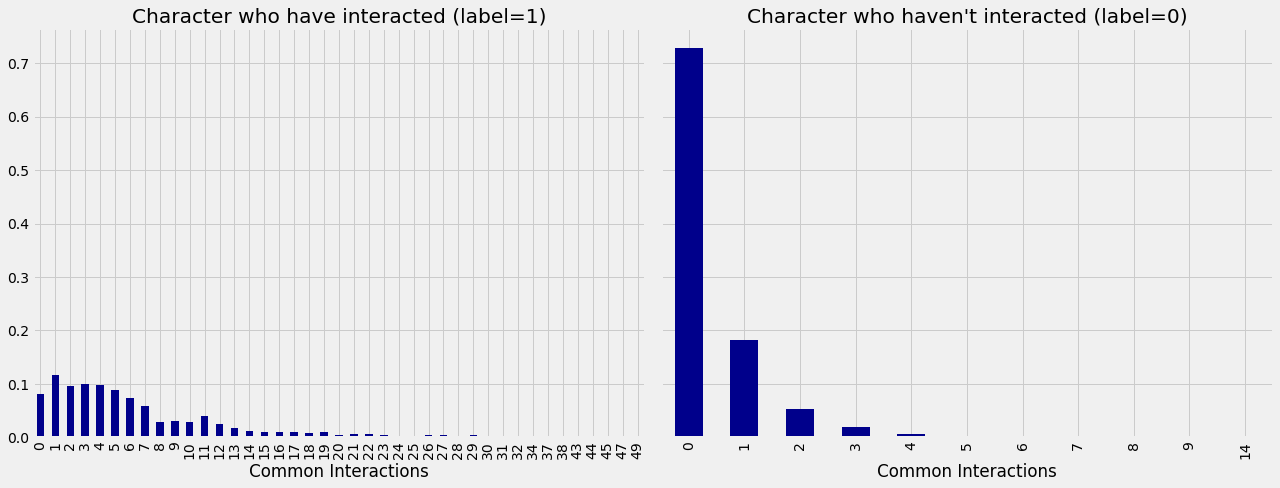

In [7]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have interacted"), (0, "haven't interacted")]
for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    interactions = filtered.toPandas()["CommonInteractions"]
    histogram =interactions.value_counts().sort_index()
    histogram /= float(histogram.sum())
    histogram.plot(kind="bar", x='Common Interactions', color="darkblue",
    ax=axs[index], title=f"Character who {title} (label={label})")
    axs[index].xaxis.set_label_text("Common Interactions")
    
plt.tight_layout()
plt.show()

## Training of model

Here is a basic model based on common interactions in order to predict the future interactions.

In [8]:
def train_model(fields, training_data):
    pipeline = create_pipeline(fields)
    model = pipeline.fit(training_data)
    return model

basic_model = train_model(["CommonInteractions"], training_data)

eval_df = spark.createDataFrame(
        [(0,), (1,), (2,), (10,), (100,)],
        ['CommonInteractions'])


(basic_model.transform(eval_df)
    .select("CommonInteractions", "probability", "prediction")
    .show(truncate=False))

+------------------+---------------------------------------+----------+
|CommonInteractions|probability                            |prediction|
+------------------+---------------------------------------+----------+
|0                 |[0.823896939539877,0.17610306046012306]|0.0       |
|1                 |[0.823896939539877,0.17610306046012306]|0.0       |
|2                 |[0.1007334690744222,0.8992665309255778]|1.0       |
|10                |[0.1007334690744222,0.8992665309255778]|1.0       |
|100               |[0.1007334690744222,0.8992665309255778]|1.0       |
+------------------+---------------------------------------+----------+



## Evaluation of the model.
We are using 4 differents metric in order to evaluate the model.


- Accuracy : The fraction of predictions our model gets right, or the total number of correct predictions divided by the total number of predictions. Note that accuracy alone can be misleading, especially when our data is unbalanced. For example, if we have a dataset containing 95 cats and 5 dogs and our model predicts that every image is a cat we’ll have a 95% accuracy score despite correctly identifying none of the dogs. The formula is $\dfrac{TruePositives+TrueNegatives}{TotalPrediction}$

- Precision :The proportion of positive identifications that are correct. A low precision score indicates more false positives. A model that produces no false positives has a precision of 1.0. It is the metric which highlight if the model can predict well the links that already exists. The formula is $\dfrac{TruePositives}{TruePositives+FalsePositives}$

- Recall(true positive rate) :The proportion of actual positives that are identified correctly. A low recall score indicates more false negatives. A model that produces no false negatives has a recall of 1.0. This metric shows if the model predicts well the linked that did not existed before. The formula is $\dfrac{TruePositives}{TruePositives+FalseNegatives}$


- Receiver operating characteristic  (ROC) curve is a plot of the Recall (true positive rate) against the False Positive rate at different classification thresholds. The area under the curve (AUC) measures the two-dimensional area underneath the ROC curve from an X-Y axis (0,0) to (1,1) where the false positive rate is defined by $\dfrac{FalsePositives}{FalsePositives+TrueNegatives}$

In [9]:
def evaluate_model(model, test_data):
    # Execute the model against the test set
    predictions = model.transform(test_data)
    # Compute true positive, false positive, false negative counts
    tp = predictions[(predictions.label == 1) &
        (predictions.prediction == 1)].count()
    fp = predictions[(predictions.label == 0) &
                     (predictions.prediction == 1)].count()
    fn = predictions[(predictions.label == 1) &
                     (predictions.prediction == 0)].count()
    # Compute recall and precision manually
    recall = float(tp) / (tp + fn)
    precision = float(tp) / (tp + fp)
    # Compute accuracy using Spark MLLib's binary classification evaluator
    accuracy = BinaryClassificationEvaluator().evaluate(predictions)
    # Compute false positive rate and true positive rate using sklearn functions
    labels = [row["label"] for row in predictions.select("label").collect()]
    preds = [row["probability"][1] for row in predictions.select
             ("probability").collect()]
    fpr, tpr, threshold = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    return { "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc, "accuracy": accuracy,
            "recall": recall, "precision": precision }


In [10]:
def display_results(results):
    results = {k: v for k, v in results.items() if k not in ["fpr", "tpr", "roc_auc"]}
    return pd.DataFrame({"Measure": list(results.keys()),
                         "Score": list(results.values())})

basic_results = evaluate_model(basic_model, test_data)
display_results(basic_results)

,Measure,Score
0,accuracy,0.806245
1,recall,0.765237
2,precision,0.833607


In [11]:
def create_roc_plot():
    plt.style.use('classic')
    fig = plt.figure(figsize=(13, 8))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rc('axes', prop_cycle=(cycler('color',
                                      ['r', 'g', 'b', 'c', 'm', 'y', 'k'])))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random score (AUC = 0.50)')
    return plt, fig

def add_curve(plt, title, fpr, tpr, roc):
    plt.plot(fpr, tpr, label=f"{title} (AUC = {roc:0.2})")
    


In [12]:
lt, fig = create_roc_plot()
add_curve(plt, "Common Interactions",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

'plt, fig = create_roc_plot()\nadd_curve(plt, "Common Interactions",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])\nplt.legend(loc=\'lower right\')\nplt.show()'

The model is quite performant but there is still a large amount of mistakes. We will improve it.

## A more complex model with 3 features
When we print the stats on 3 features for the people who have interacted and those who don't we can see the character who have interacted have a higher mean for the 3 following features.
%TODO Expliquer qui fait quoi

In [13]:
(training_data.filter(training_data["label"]==1)
    .describe()
    .select("summary", "CommonInteractions", "prefAttachment", "totalNeighbors")
    .show())
(training_data.filter(training_data["label"]==0)
    .describe()
    .select("summary", "CommonInteractions", "prefAttachment", "totalNeighbors")
    .show())

+-------+------------------+------------------+------------------+
|summary|CommonInteractions|    prefAttachment|    totalNeighbors|
+-------+------------------+------------------+------------------+
|  count|              1849|              1849|              1849|
|   mean| 6.472147106544078| 649.0016224986479|  47.7658193618172|
| stddev| 6.590397693758528|1042.7011892287317|31.153957172436126|
|    min|                 0|                 2|                 3|
|    max|                49|              7968|               159|
+-------+------------------+------------------+------------------+

+-------+------------------+-----------------+------------------+
|summary|CommonInteractions|   prefAttachment|    totalNeighbors|
+-------+------------------+-----------------+------------------+
|  count|              1849|             1849|              1849|
|   mean|0.4402379664683613|61.00378583017847| 17.35803136830719|
| stddev|0.9955654637902858|127.8862940523298|17.254947581369585|


In [14]:
fields = ["CommonInteractions", "prefAttachment", "totalNeighbors"]
graphy_model = train_model(fields, training_data)

graphy_results = evaluate_model(graphy_model, test_data)
display_results(graphy_results)


,Measure,Score
0,accuracy,0.884344
1,recall,0.817156
2,precision,0.811659


In [15]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Interactions",
          basic_results["fpr"], basic_results["tpr"],
                              basic_results["roc_auc"])
add_curve(plt, "Graphy",
          graphy_results["fpr"], graphy_results["tpr"],
          graphy_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

'plt, fig = create_roc_plot()\nadd_curve(plt, "Common Interactions",\n          basic_results["fpr"], basic_results["tpr"],\n                              basic_results["roc_auc"])\nadd_curve(plt, "Graphy",\n          graphy_results["fpr"], graphy_results["tpr"],\n          graphy_results["roc_auc"])\nplt.legend(loc=\'lower right\')\nplt.show()'

## Which features are important ?

In [16]:
def plot_feature_importance(fields, feature_importances):
    df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

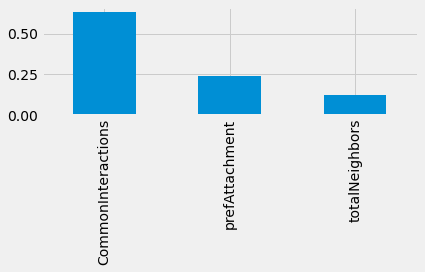

In [17]:
rf_model = graphy_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

## Plotting a decision tree (WIP package on jupyter...)

In [18]:
'''from spark_tree_plotting import export_graphviz
dot_string = export_graphviz(rf_model.trees[0],
                             featureNames=fields, categoryNames=[], classNames=["True", "False"],
                             filled=True, roundedCorners=True, roundLeaves=True)
with open("/tmp/rf.dot", "w") as file:
    file.write(dot_string)'''

'from spark_tree_plotting import export_graphviz\ndot_string = export_graphviz(rf_model.trees[0],\n                             featureNames=fields, categoryNames=[], classNames=["True", "False"],\n                             filled=True, roundedCorners=True, roundLeaves=True)\nwith open("/tmp/rf.dot", "w") as file:\n    file.write(dot_string)'

## Adding new features: triangle and clusters

Need to call some functions in Neo4j.

```cypher
call gds.graph.create("G","Character",
{
	Interacts : {
    	type:"Interacts",
        properties: 'weight',
        orientation:'UNDIRECTED'
    }
    })
```
    
```cypher
CALL gds.triangleCount.write("G", {
writeProperty:'trianglesTest'})
```
```cypher
CALL gds.localClusteringCoefficient.write("G", {
writeProperty:'coefficientTest'})
```


```cypher
call gds.graph.create("G_ea","Character",
{
	Interacts_early : {
    	type:"Interacts_early",
        properties: 'weight',
        orientation:'UNDIRECTED'
    }
    })
```

```cypher
CALL gds.triangleCount.write("G_ea", {
writeProperty:'trianglesTrain'})
```

```cypher
CALL gds.localClusteringCoefficient.write("G", {
writeProperty:'coefficientTrain'})
```

In [19]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
            pair.node2 AS node2,
            apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]])
            AS minTriangles,
            apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]])
            AS maxTriangles,
            apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]])
            AS minCoefficient,
            apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]])
            AS maxCoefficient
    """
    params = {
        "pairs": [{"node1": row["node1"], "node2": row["node2"]}
                            for row in data.collect()],
        "trianglesProp": triangles_prop,
        "coefficientProp": coefficient_prop
    }
    features = spark.createDataFrame(graph.run(query, params).to_data_frame())
    return data.join(features, ["node1", "node2"])

training_data = apply_triangles_features(training_data, "trianglesTrain", "coefficientTrain")
test_data = apply_triangles_features(test_data, "trianglesTest", "coefficientTest")

In [20]:
(training_data.filter(training_data["label"]==1)
.describe()
.select("summary", "minTriangles", "maxTriangles",
"minCoefficient", "maxCoefficient")
.show())
(training_data.filter(training_data["label"]==0)
.describe()
.select("summary", "minTriangles", "maxTriangles", "minCoefficient",
"maxCoefficient")
.show())

+-------+-----------------+------------------+-------------------+-------------------+
|summary|     minTriangles|      maxTriangles|     minCoefficient|     maxCoefficient|
+-------+-----------------+------------------+-------------------+-------------------+
|  count|             1849|              1849|               1849|               1849|
|   mean|34.01406165494862|147.98918334234722|0.17158540902414815| 0.4206154570452622|
| stddev| 53.1987799838798|117.42364605776545| 0.1469681737764032|0.23667876736964535|
|    min|                0|                 0|                0.0|                0.0|
|    max|              325|               383|                1.0|                1.0|
+-------+-----------------+------------------+-------------------+-------------------+

+-------+-----------------+-----------------+-------------------+-------------------+
|summary|     minTriangles|     maxTriangles|     minCoefficient|     maxCoefficient|
+-------+-----------------+-----------------

In [21]:
fields = ["CommonInteractions", "prefAttachment", "totalNeighbors",
            "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient"]
triangle_model = train_model(fields, training_data)
triangle_results = evaluate_model(triangle_model, test_data)
display_results(triangle_results)

,Measure,Score
0,accuracy,0.906434
1,recall,0.860798
2,precision,0.822430


In [22]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Interactions",
basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "Graphy",
graphy_results["fpr"], graphy_results["tpr"],
graphy_results["roc_auc"])
add_curve(plt, "Triangles",
triangle_results["fpr"], triangle_results["tpr"],
triangle_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

'plt, fig = create_roc_plot()\nadd_curve(plt, "Common Interactions",\nbasic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])\nadd_curve(plt, "Graphy",\ngraphy_results["fpr"], graphy_results["tpr"],\ngraphy_results["roc_auc"])\nadd_curve(plt, "Triangles",\ntriangle_results["fpr"], triangle_results["tpr"],\ntriangle_results["roc_auc"])\nplt.legend(loc=\'lower right\')\nplt.show()'

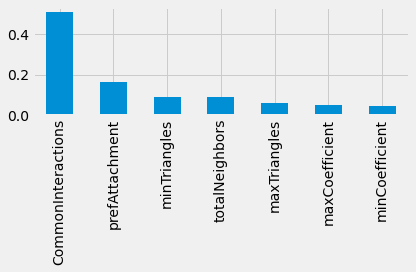

In [23]:
rf_model = triangle_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

## Community Detection

```cypher
CALL gds.louvain.stream("G",{includeIntermediateCommunities:True})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity
```
```cypher
Call gds.labelPropagation.write("G", {writeProperty:"partitionTest"})
 ```

```cypher
CALL gds.louvain.stream("G_ea",{includeIntermediateCommunities:True})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity
```
```cypher
Call gds.labelPropagation.write("G_ea", {writeProperty:"partitionTrain"})
```

In [24]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
            pair.node2 AS node2,
            CASE WHEN p1[$partitionProp] = p2[$partitionProp] THEN
            1 ELSE 0 END AS samePartition,
            CASE WHEN p1[$louvainProp] = p2[$louvainProp] THEN
            1 ELSE 0 END AS sameLouvain
    """
    params = {
        "pairs": [{"node1": row["node1"], "node2": row["node2"]} for
                            row in data.collect()],
        "partitionProp": partition_prop,
        "louvainProp": louvain_prop
    }
    features = spark.createDataFrame(graph.run(query, params).to_data_frame())
    return data.join(features, ["node1", "node2"])
training_data = apply_community_features(training_data, "partitionTrain", "louvainTrain")
test_data = apply_community_features(test_data, "partitionTest", "louvainTest")

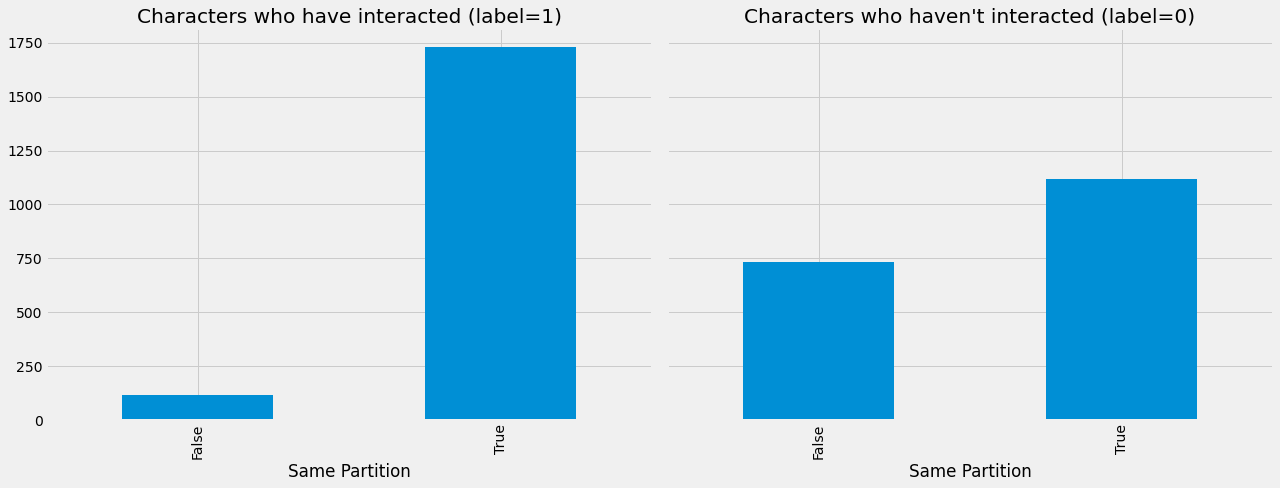

In [25]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have interacted"), (0, "haven't interacted")]
for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    values = (filtered.withColumn('samePartition',
            F.when(F.col("samePartition") == 0, "False")
            .otherwise("True"))
            .groupby("samePartition")
            .agg(F.count("label").alias("count"))
            .select("samePartition", "count")
            .toPandas())
    values.set_index("samePartition", drop=True, inplace=True)
    values.plot(kind="bar", ax=axs[index], legend=None,
                title=f"Characters who {title} (label={label})")
    axs[index].xaxis.set_label_text("Same Partition")
plt.tight_layout()
plt.show()

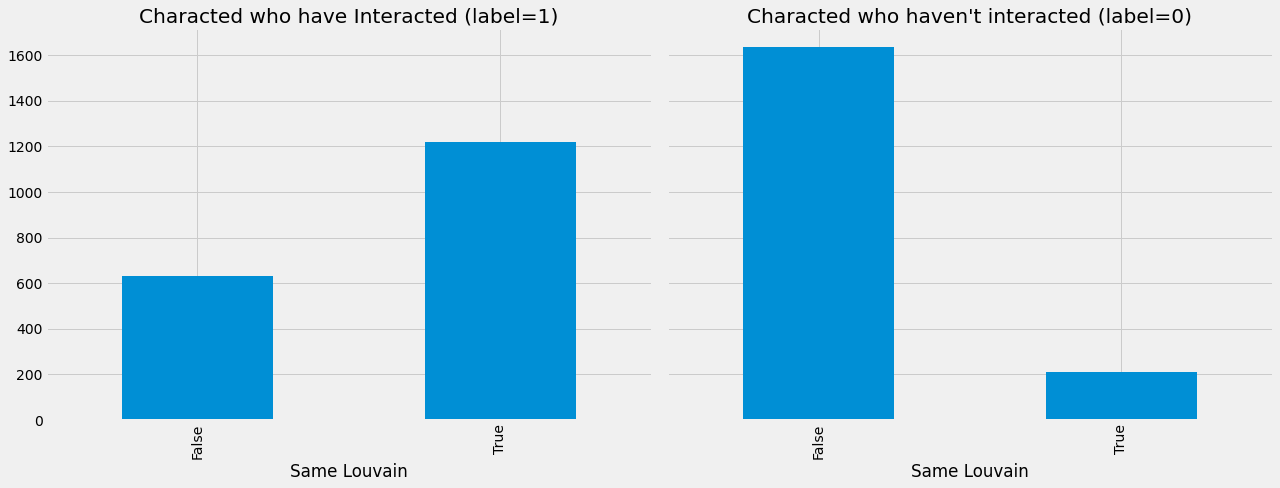

In [26]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have Interacted"), (0, "haven't interacted")]
for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    values = (filtered.withColumn('sameLouvain',
            F.when(F.col("sameLouvain") == 0, "False")
            .otherwise("True"))
            .groupby("sameLouvain")
            .agg(F.count("label").alias("count"))
            .select("sameLouvain", "count")
            .toPandas())
    values.set_index("sameLouvain", drop=True, inplace=True)
    values.plot(kind="bar", ax=axs[index], legend=None,
    title=f"Characted who {title} (label={label})")
    axs[index].xaxis.set_label_text("Same Louvain")
plt.tight_layout()
plt.show()

In [27]:
fields = ["CommonInteractions", "prefAttachment", "totalNeighbors", "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", "samePartition", "sameLouvain"]
community_model = train_model(fields, training_data)

In [28]:
community_results = evaluate_model(community_model, test_data)
display_results(community_results)

,Measure,Score
0,accuracy,0.926338
1,recall,0.890143
2,precision,0.848029


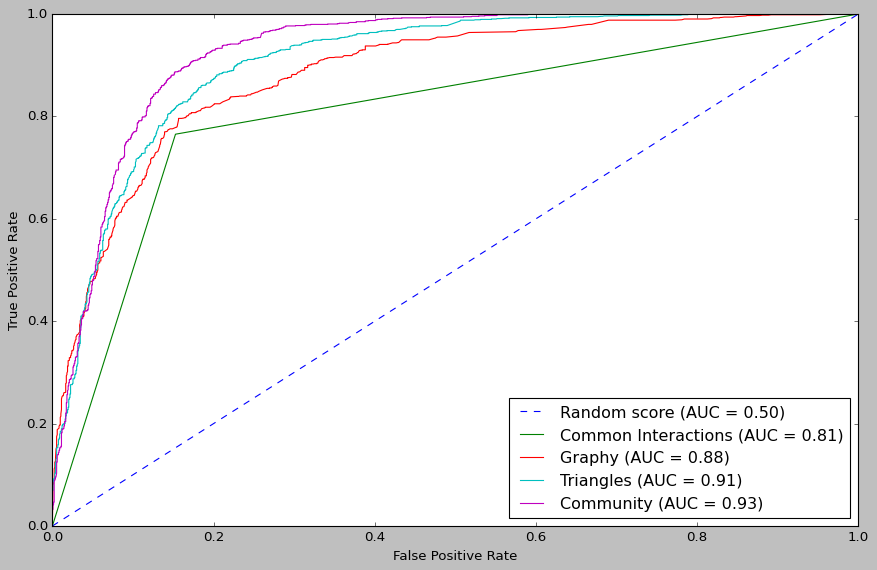

In [29]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Interactions",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"], graphy_results["roc_auc"])
add_curve(plt, "Triangles", triangle_results["fpr"], triangle_results["tpr"], triangle_results["roc_auc"])
add_curve(plt, "Community", community_results["fpr"], community_results["tpr"], community_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

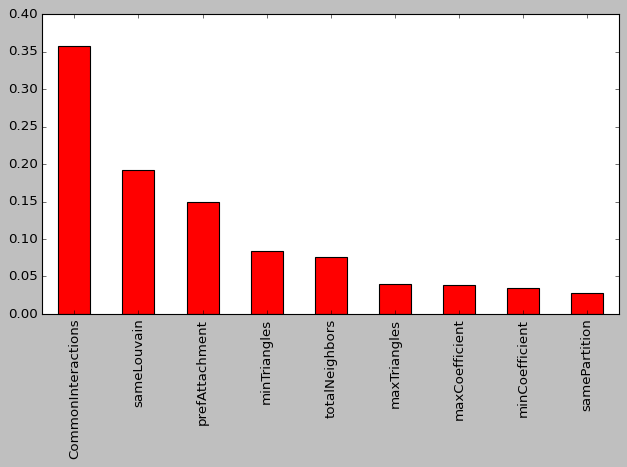

In [30]:
rf_model = community_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)